# Testing average treatment effect (ATE)

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_2392428/966458967.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
policy0 = cri.policies.OnehotPolicy(treatment=0)
policy1 = cri.policies.OnehotPolicy(treatment=1)
ate_policy = cri.policies.ATEPolicy(target_treatment=1, base_treatment=0)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(4000)

In [4]:
def plot_bound_tightness(policy):
    def get_lower_bound_ci(Gamma):
        estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
        estimator.fit(Y, T, X, p_t, policy)
        return estimator.predict_ci()

    def get_upper_bound_ci(Gamma):
        estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30)
        estimator.fit(-Y, T, X, p_t, policy)
        low, high = estimator.predict_ci()
        return -high, -low

    Gammas = [1 + i / 10 for i in range(11)]
    lower_bound_cis = [get_lower_bound_ci(Gamma) for Gamma in Gammas]
    upper_bound_cis = [get_upper_bound_ci(Gamma) for Gamma in Gammas]

    lower_bounds = [(l + h) / 2 for (l, h) in lower_bound_cis]
    upper_bounds = [(l + h) / 2 for (l, h) in upper_bound_cis]
    lower_bound_cis_high = [h for (l, h) in lower_bound_cis]
    upper_bound_cis_high = [h for (l, h) in upper_bound_cis]
    lower_bound_cis_low = [l for (l, h) in lower_bound_cis]
    upper_bound_cis_low = [l for (l, h) in upper_bound_cis]

    lower_line = plt.plot(Gammas, lower_bounds, color=tab10(0))[0]
    upper_line = plt.plot(Gammas, upper_bounds, color=tab10(0))[0]
    lower_band = plt.fill_between(
        Gammas, lower_bound_cis_low, lower_bound_cis_high, color=tab10(0), alpha=0.1
    )
    upper_band = plt.fill_between(
        Gammas, upper_bound_cis_low, upper_bound_cis_high, color=tab10(0), alpha=0.1
    )
    plt.legend([(lower_line, upper_line, lower_band, upper_band)], ["KCMC estimator ($D=30$)"])
    plt.xlabel(r"Sensitivity parameter $\Gamma$")
    plt.ylabel(r"Policy value")
    if isinstance(policy, cri.policies.ATEPolicy):
        plt.savefig(f"fig/test_ate_{policy.__class__.__name__}.pdf")
    else:
        plt.savefig(f"fig/test_ate_{policy.__class__.__name__}-{policy.treatment}.pdf")

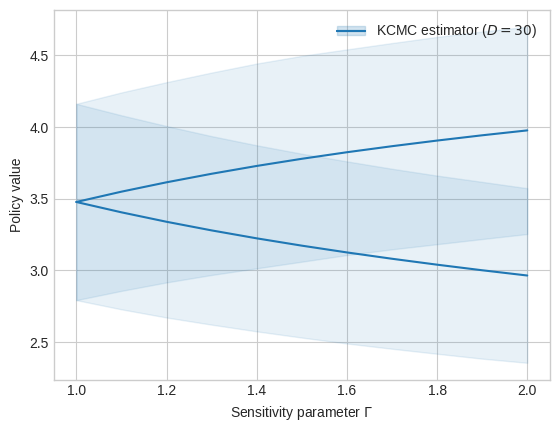

In [5]:
plot_bound_tightness(policy0)

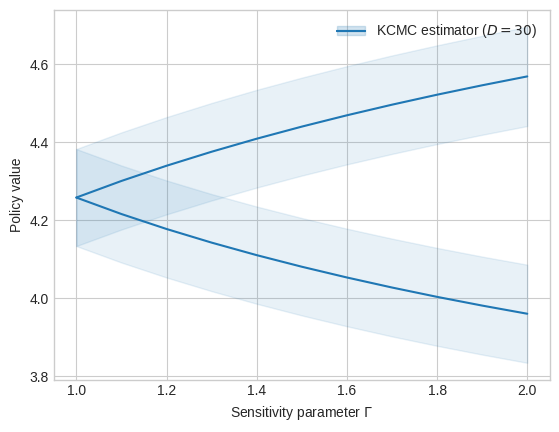

In [6]:
plot_bound_tightness(policy1)

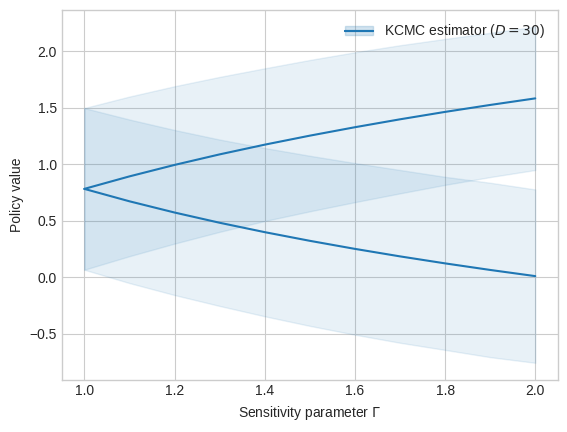

In [8]:
plot_bound_tightness(ate_policy)